In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebooks.util import get_flow_families

In [51]:
df = pd.read_json('cpu-gpu-results.json')

In [52]:
dicts = [{**get_flow_families(f), **{'flow': f}} for f in df['flow']]

family = pd.Series(['Continuous' for _ in range(len(df))])
family[[d['flow_subfamily'] == 'coupling' for d in dicts]] = 'Coupling'
family[[d['flow_subfamily'] == 'masked' and 'ia' not in d['flow'] for d in dicts]] = 'Masked (forward)'
family[[d['flow_subfamily'] == 'masked' and 'ia' in d['flow'] for d in dicts]] = 'Masked (inverse)'
family[[d['flow_subfamily'] == 'iterative' for d in dicts]] = 'Contractive residual'
family[[d['flow_subfamily'] == 'matrix-det' for d in dicts]] = 'Mat-det residual'

In [53]:
df['family'] = family

In [54]:
df.columns

Index(['flow', 'device', 'dimensionality', 'log_prob_time',
       'standard_backward_time', 'sample_time', 'sample_backward_time',
       'family'],
      dtype='object')

In [55]:
sample_backward_time_col = 'sample_backward_time'
standard_backward_time_col = 'standard_backward_time'
log_prob_time_col = 'log_prob_time'
sample_time_col = 'sample_time'

In [56]:
empty_sample_backward = df[sample_backward_time_col].isna()
df.loc[empty_sample_backward, sample_backward_time_col] = df.loc[empty_sample_backward, standard_backward_time_col]
df['backward_time'] = np.minimum(df[sample_backward_time_col], df[standard_backward_time_col])

In [57]:
df['order'] = df['family'].map(
    dict(
        zip(
            ['Coupling', 'Continuous', 'Contractive residual', 'Masked (inverse)', 'Masked (forward)',
             'Mat-det residual'],
            [1, 2, 5, 3, 4, 6]
        )
    )
)
df = df.sort_values('order')
df = df.drop('order', axis=1)
df = df[df['dimensionality'].isin([2, 4, 8, 16, 32, 64, 128])]
# df = df[df['dimensionality'] <= 128]

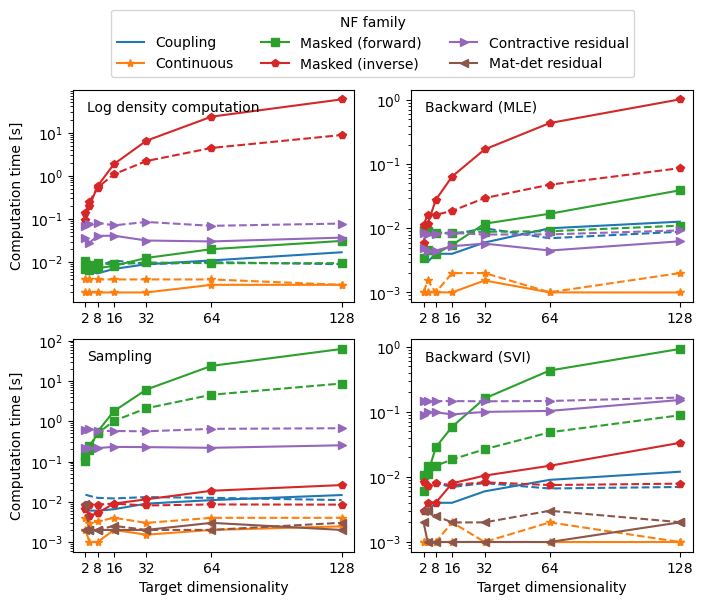

In [58]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = [axes[0, 0], axes[1, 0], axes[0, 1], axes[1, 1]]

axes[0].set_ylabel('Computation time [s]')
axes[1].set_ylabel('Computation time [s]')
axes[1].set_xlabel('Target dimensionality')
axes[3].set_xlabel('Target dimensionality')
axes[0].text(0.05, 0.95, 'Log density computation', transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(0.05, 0.95, 'Sampling', transform=axes[1].transAxes, ha='left', va='top')
axes[2].text(0.05, 0.95, 'Backward (MLE)', transform=axes[2].transAxes, ha='left', va='top')
axes[3].text(0.05, 0.95, 'Backward (SVI)', transform=axes[3].transAxes, ha='left', va='top')

families = [
    'Coupling',
    'Continuous',
    'Masked (forward)',
    'Masked (inverse)',
    'Contractive residual',
    'Mat-det residual',
]

markers = [
    '',
    '*',
    's',
    'p',
    '>',
    '<',
]

for color, family, marker in zip(color_cycle, families, markers):
    subset = df[df['family'] == family]

    for device in subset['device'].unique():
        gb = subset[subset['device'] == device].groupby('dimensionality')[
            log_prob_time_col].median().reset_index().set_index('dimensionality')
        axes[0].plot(gb.index, gb[log_prob_time_col], linestyle='--' if device == 'cuda' else None, c=color, marker=marker)

    for device in subset['device'].unique():
        gb = subset[subset['device'] == device].groupby('dimensionality')[
            sample_time_col].median().reset_index().set_index('dimensionality')
        axes[1].plot(gb.index, gb[sample_time_col], linestyle='--' if device == 'cuda' else None, c=color,
                     label=f'{family}' if device == 'cpu' else None, marker=marker)

    for device in subset['device'].unique():
        gb = subset[subset['device'] == device].groupby('dimensionality')[
            standard_backward_time_col].median().reset_index().set_index('dimensionality')
        axes[2].plot(gb.index, gb[standard_backward_time_col], linestyle='--' if device == 'cuda' else None, c=color, marker=marker)

    for device in subset['device'].unique():
        gb = subset[subset['device'] == device].groupby('dimensionality')[
            sample_backward_time_col].median().reset_index().set_index('dimensionality')
        axes[3].plot(gb.index, gb[sample_backward_time_col], linestyle='--' if device == 'cuda' else None, c=color, marker=marker)

for ax in axes:
    ax.set_xticks([2, 8, 16, 32, 64, 128])
    # ax.set_xscale('log')
    ax.set_yscale('log')

fig.legend(bbox_to_anchor=(0.5, 1.025), loc='upper center', ncol=3, title='NF family')
fig.subplots_adjust(wspace=0.2, hspace=0.175)

fig.savefig('images/cpu-vs-gpu.pdf', bbox_inches='tight')
fig.savefig('images/cpu-vs-gpu.png', bbox_inches='tight', dpi=600)

plt.show()